<table>
  <tr>
    <td><div align="left"><font size="30" >Practical Week 5: Robotic Vision</font></div></td>
  </tr>
</table>

<tr>
<td><div align="left"><font size="10" >4. Training a fully connected neural network for digit classification</font></div></td>
</tr>

### Import all the packages required. 
If you are using GPU, change `FLAG_GPU` to `True` (we are not doing heavy computation in this notebook so `FLAG_GPU` is not that important, and I don't have a GPU to test things so ... if you want it to work with GPU you have to look into how to do that yourself)

In [1]:
# Change this flag if using a GPU
FLAG_GPU = False


import numpy as np
import matplotlib.pyplot as plt

# import time for timekeeping
import time

# Pytorch (Our Deep Learning Framework)
import torch

# Torch Data Loader (this will be helful to load image)
from torch.utils.data import Dataset, DataLoader

# datasets have mnist if using coustom images import io from skimage
from torchvision import datasets, transforms, utils

# stores different optimizors like SGD
import torch.optim as optim

# Some torch functions that are used multiple times
import torch.nn.functional as F
import torch.nn as nn

## Let's Define a Multi Layer Perceptron "__ init __ " function
* Any network has an `* __ init __ *` function that initializes all the layers of the NN that require learnable parameters.
* A MLP is a stack of fully connected layers. In this example we use three fully connected layers named :`fc0`, `fc1` and `fc2`.
* Note that each fully connected layer has a number of input neurons that connect to a number of output neurons. 
* These input and output dimensions are specified in the fc layer initialization.
* If a fully connected layer connects to another, its output size = input size of the fully connected layer that follows.
* The number of paramenters in any fully connected layer is #Input x #Output (and 1 bias per output).

## How do we write a forward function?
* `torch.flatten(x, start_dim = dim)` converts an image-like entity to a vector.
* Remeber that you need activations after every fully connected layer. In this case we use ReLu. 
* Notice the `log_softmax` layer at the end. This is a softmax activation function followed by log function as the name suggests.

In [2]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        
        # First fully connected layer's input image is 28x28 = 784 dim.
        self.fc0 = nn.Linear(784, 256) # nparam = 784*256 = 38400
        
        # Two more fully connected layers
        self.fc1 = nn.Linear(256, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        # Flattens the image-like structure into vectors
        x = torch.flatten(x, start_dim=1)

        # fully connected layers with activations
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # Outputs are log(p) so softmax followed by log.
        #return(x)
        output = F.log_softmax(x, dim=1) # CHAZ: ie. creates probabilities between 0 and 1 rather than numbers between 0 and x
        return output

## Initializing an instance of the defined network here.
* Note that putting a network to GPU is as simple as writing .cuda() at the end of the instance. In this notebook the code inside the command `if FLAG_GPU` shows all the modifications you need to run your code on GPU.

In [3]:
net = MLPNet()
if FLAG_GPU:
    print('Using GPU:', torch.cuda.get_device_name(0))
    net.cuda()
    print(net)
else:
    print(net)

MLPNet(
  (fc0): Linear(in_features=784, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


## Dataloaders and Transforms.
* `dataset.MNIST` in pytorch implements the functionality to download and process MNIST data.
* dataloader function usually allows for loading parts of training and test data in minibatches.
* It can use some simple transformations implemented in class transforms that assists training. For example normalizing, resizing or cropping images.
* The functionality of the dataset, transform and dataloader classes are usually added to suit new data and training proceedure related to the problem at hand.

In [11]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Training dataset and training loader.
trainset = datasets.MNIST(root='./Practical05_Support/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
# Test dataset and loader.
testset = datasets.MNIST(root='./Practical05_Support/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

## Here we see sample usage of loading some MNIST training data.
* What does our training minibatch look like?
* At times simple visualization and print statements allow for understanding/debugging effectively.

shape of images torch.Size([32, 1, 28, 28])


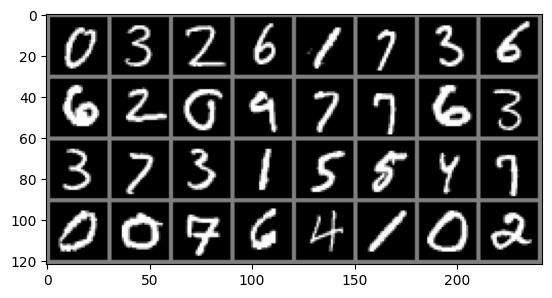

Labels were:
[[0 3 2 6 1 7 3 6]
 [6 2 0 9 7 7 6 3]
 [3 7 3 1 5 5 4 7]
 [0 0 7 6 4 1 0 2]]


In [5]:
def imshow(img, l):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    print('Labels were:')
    print(l.reshape(-1,8).numpy())

# Load sample data
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('shape of images', images.shape)

# display batch
imshow(utils.make_grid(images),labels)

## Loss function for learning.
* NLLLoss: The abbrivation NLL stands for Negetive log likelihood. It is however a bit of misnomer as the log is not included in the loss itself but was part of the network defination above. 
* NOTE: When you want to get the probability/likelihood of an image being of a perticular class you need to remove the log from the forward function and use simple softmax activation at test time. Alternatively simply use `exp` function from torch to invert log and leave the forward function as it is. 

## Optimizer
* pytorch has various optimization rutines (beyond SGD) pre-implemented.
* class `optim` will take care of backpropogation with these different optimizations for learning as long as the network definition with appropriate forward function is written correctly.
* Here we just use SGD with learning rate 0.001 and momentum 0.9.

In [6]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
if FLAG_GPU:
    criterion = criterion.cuda()

## This cell of the notebook is training the network.

* The first for loop goes through the entire data 5 times (We run 5 epochs for our training).
* The simple steps for training a NN with pytorch are:
    * Load data in minibatches.
    * Set gradients for all the network parameters to zero (dont forget this)
    * Pass data to the NN using a `net.forward()` to compute layer by layer output.
        * Intermediate outputs can be returned as extra variables in forward function.
    * Compute the loss from the output (remember it is defined above).
    * Use `loss.backward()` to compute all the gradients by appropriately applying chain rule! 
        * It actually knows how to differentiate things!!!
    * Use `optimizer.step()` to update the weights.
    
## At the end of every epoch usually we check if NN generalizes.
* Generalization is critical in learning.
* We evaluate the performance of our NN on new data, for which the NN loss was not minimized.
* The `torch.no_grad()` command forces the following code to not keep track of the gradients as for testing we don't need them.
* As no gradients are maintained, the code runs faster!
* It is very good practice to make use of `no_grad` function to ensure that we dont accidently minimize loss on the data we are testing the performance on.


 


In [7]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    
    # Simply for time keeping
    start_time = time.time()
    # Loop over all training data
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
 
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward 
        if FLAG_GPU:
            outputs = net(inputs.cuda())
            loss = criterion(outputs, labels.cuda())
        else:
            outputs = net(inputs)
            loss = criterion(outputs, labels)

        # Compute Gradients
        loss.backward()
        # BackProp
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        # endif
    # end for over minibatches epoch finishes
    end_time = time.time()

    # test the network every epoch on test example
    correct = 0
    total = 0

    # Test after the epoch finishes (no gradient computation needed)
    with torch.no_grad():
        for data in testloader:
            # load images and labels
            images, labels = data

            if FLAG_GPU:
                outputs = net(images.cuda())
                # note here we take the max of all probability
                _, predicted = torch.max(outputs.cpu(), 1)
            else:
                outputs = net(images)
                # note here we take the max of all probability
                _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

      #end for
    #end with
    print('Epoch', epoch+1, 'took', end_time-start_time, 'seconds')
    print('Accuracy of the network after', epoch+1, 'epochs is' , 100*correct/total)

print('Finished Training')

[1,   100] loss: 2.231
[1,   200] loss: 1.952
[1,   300] loss: 1.430
[1,   400] loss: 0.991
[1,   500] loss: 0.768
[1,   600] loss: 0.653
[1,   700] loss: 0.567
[1,   800] loss: 0.518
[1,   900] loss: 0.468
[1,  1000] loss: 0.474
[1,  1100] loss: 0.440
[1,  1200] loss: 0.384
[1,  1300] loss: 0.386
[1,  1400] loss: 0.405
[1,  1500] loss: 0.368
[1,  1600] loss: 0.404
[1,  1700] loss: 0.370
[1,  1800] loss: 0.366
Epoch 1 took 12.04650092124939 seconds
Accuracy of the network after 1 epochs is 90.5
[2,   100] loss: 0.344
[2,   200] loss: 0.362
[2,   300] loss: 0.357
[2,   400] loss: 0.333
[2,   500] loss: 0.349
[2,   600] loss: 0.330
[2,   700] loss: 0.308
[2,   800] loss: 0.296
[2,   900] loss: 0.297
[2,  1000] loss: 0.316
[2,  1100] loss: 0.301
[2,  1200] loss: 0.311
[2,  1300] loss: 0.311
[2,  1400] loss: 0.280
[2,  1500] loss: 0.295
[2,  1600] loss: 0.279
[2,  1700] loss: 0.295
[2,  1800] loss: 0.292
Epoch 2 took 10.909823894500732 seconds
Accuracy of the network after 2 epochs is 91.9

## Using the NN

Labels were: 4


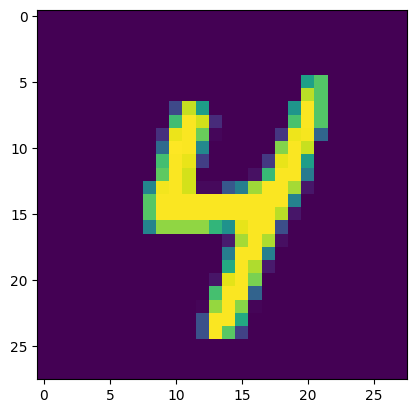

In [8]:
test_image = images[3]
plt.imshow(np.array(test_image).transpose((1,2,0))[:, :, 0])
print(f'Labels were: {labels[3]}')

In [9]:
input = images[3]
# run the forward pass
with torch.no_grad():
    if FLAG_GPU:
        outputs = net(input.cuda())
    else:
        outputs = net(input)
        
    _, predicted = torch.max(outputs, 1)

print(f"The network predicted: {predicted.item()}")

The network predicted: 4


### Flux Question 4
Looking at the difference between more traditional computer vision and more recent machine learning approaches. What is similar / what is different?

Particularly for training computer vision models, what are critical components for these techniques?
